## A) For MNIST dataset, run a TF in supervised mode (train/test) and report results 

## Using GPU:

In [1]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.INFO)

1.6.0


In [2]:
#download mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#start interactive session
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))

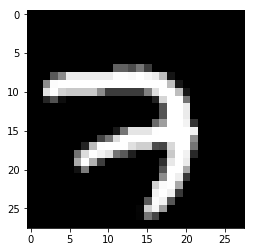

In [4]:
#data exploration
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(np.reshape(mnist.train.images[0], [28, 28]), cmap='gray') #current shape is 28 x 28
plt.show()

### Drop classes 8 and 9:

In [5]:
mnist_train_data = np.array([x for (x,y) in zip(mnist.train.images,mnist.train.labels) if y[8]==0 and y[9]==0])
mnist_train_labels = np.array([y[0:8] for y in mnist.train.labels if y[8]==0 and y[9]==0])

In [6]:
mnist_train_data.shape, mnist_train_labels.shape

((44157, 784), (44157, 8))

In [7]:
mnist_test_data = np.array([x for (x,y) in zip(mnist.test.images,mnist.test.labels) if y[8]==0 and y[9]==0])
mnist_test_labels = np.array([y[0:8] for y in mnist.test.labels if y[8]==0 and y[9]==0])

In [8]:
mnist_test_data.shape, mnist_test_labels.shape

((8017, 784), (8017, 8))

### resize_by_padding zeroes to 28x28 image to make it 32x32 

In [13]:
def resize_by_padding(images):
    resized_images = []
    print("Total", len(images), "images..")
    
    for i in range(len(images)):
        
        if i%1000 == 0:
            print("Resized", i, "images till now...")
        
        """
        t= tf.constant(images[i], shape=[28,28])
        paddings=tf.constant([[2,2], [2,2]])
        var = tf.pad(t, paddings, "CONSTANT")  #converting to array
        b = tf.reshape(var,[1024]) 
        tempnmpy = b.eval()
        """
        tempnmpy = np.zeros([32,32])
        b = np.reshape(images[i], [28, 28])
        tempnmpy[:b.shape[0], :b.shape[1]] = b
        tempnmpy = tempnmpy.reshape(1024)
        #print(tempnmpy)
        #plt.imshow(np.reshape(tempnmpy, [32, 32]), cmap='gray')
        #plt.show()
        
        resized_images.append(tempnmpy)
    return np.array(resized_images)

In [14]:
mnist_train_data = resize_by_padding(mnist_train_data)

Total 44157 images..
Resized 0 images till now...
Resized 1000 images till now...
Resized 2000 images till now...
Resized 3000 images till now...
Resized 4000 images till now...
Resized 5000 images till now...
Resized 6000 images till now...
Resized 7000 images till now...
Resized 8000 images till now...
Resized 9000 images till now...
Resized 10000 images till now...
Resized 11000 images till now...
Resized 12000 images till now...
Resized 13000 images till now...
Resized 14000 images till now...
Resized 15000 images till now...
Resized 16000 images till now...
Resized 17000 images till now...
Resized 18000 images till now...
Resized 19000 images till now...
Resized 20000 images till now...
Resized 21000 images till now...
Resized 22000 images till now...
Resized 23000 images till now...
Resized 24000 images till now...
Resized 25000 images till now...
Resized 26000 images till now...
Resized 27000 images till now...
Resized 28000 images till now...
Resized 29000 images till now...
Re

In [15]:
mnist_test_data = resize_by_padding(mnist_test_data)

Total 8017 images..
Resized 0 images till now...
Resized 1000 images till now...
Resized 2000 images till now...
Resized 3000 images till now...
Resized 4000 images till now...
Resized 5000 images till now...
Resized 6000 images till now...
Resized 7000 images till now...
Resized 8000 images till now...


New shapes:

In [16]:
mnist_train_data.shape, mnist_train_labels.shape, mnist_test_data.shape, mnist_test_labels.shape

((44157, 1024), (44157, 8), (8017, 1024), (8017, 8))

### All variables converted to float16

In [17]:
x = tf.placeholder(tf.float16, shape=[None, 1024])
y_ = tf.placeholder(tf.float16, shape=[None, 8])

In [18]:
W = tf.Variable(tf.zeros([1024,8], dtype=tf.float16), dtype=tf.float16)
b = tf.Variable(tf.zeros([8], dtype=tf.float16), dtype=tf.float16)

In [19]:
#run session
sess.run(tf.global_variables_initializer())

In [20]:
y = tf.matmul(x,W) + b

In [21]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [22]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [24]:
#get batches for training
def get_batch(X, y, batch_size = 100):
    n = X.shape[0]
    batch = np.floor(np.random.rand(batch_size)*n).astype(int)
    batch_x = X[batch,:]
    batch_y = y[batch,:]
    return batch_x, batch_y

In [25]:
#train:
for _ in range(1000):
    batch_x, batch_y = get_batch(mnist_train_data, mnist_train_labels, 100)
    train_step.run(feed_dict={x: batch_x, y_: batch_y})

In [29]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [30]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float16))

In [31]:
#Accuracy
print(sess.run(accuracy, feed_dict={x: mnist_test_data, y_: mnist_test_labels}))

0.947


In [32]:
# Predict single images
n_images = 4
# Get images from test set
test_images = mnist_test_data[:n_images]

In [33]:
test_labels = mnist_test_labels[:n_images]

In [34]:
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)

In [35]:
prediction=tf.argmax(y,1) 

In [36]:
preds = prediction.eval(feed_dict={x: test_images}, session=sess)

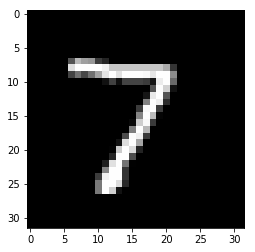

Model prediction: 7


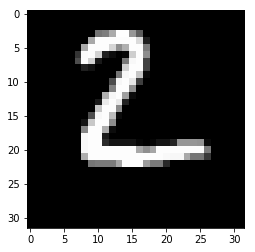

Model prediction: 2


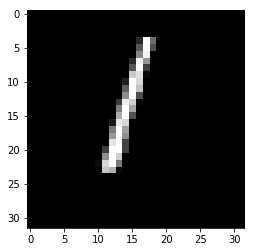

Model prediction: 1


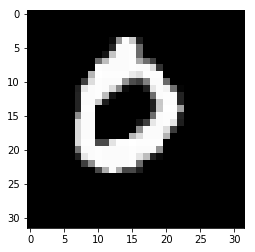

Model prediction: 0


In [38]:
# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [32, 32]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])

________